### Initialize our environment.
Good luck getting the entire environment set up. :D

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

Using TensorFlow backend.


### Loading our weights and model.
We are saving our model files in the 'model' directory.
Lets load them into tensorflow!

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "./model/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


### Success!

If you've made it this far, the model is successfully loaded into memory.
The middleware below can be ignored for now.

In [4]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

The 'input' directory holds all of the images we are going to train against.

Found 10 images...


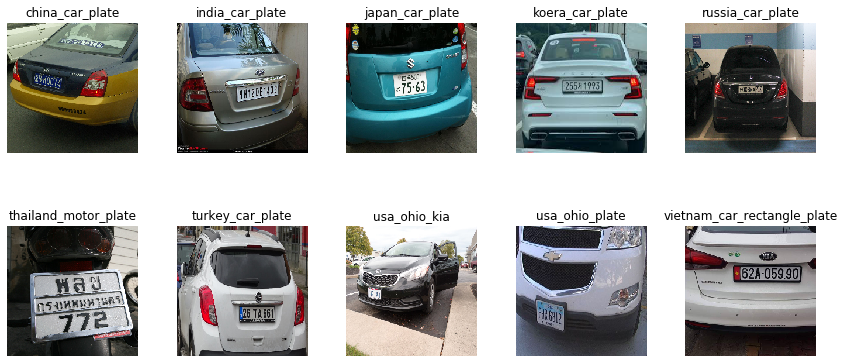

In [5]:
# Create a list of image paths 
image_paths = glob.glob("input/*.jpg")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 2
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

### Success!!!

We have listed the directory of images, everything seems to be smooth sailing so far.

From here, we have a couple goals.
- Locate the cordinates of the license plates on the vehichles.
- Crop said license plate into its own image.

Detect 1 plate(s) in japan_car_plate
Coordinate of plate(s) in image: 
 [array([[362.02933277, 624.24241604, 635.18664064, 372.97355737],
       [309.4400115 , 284.90693992, 412.18672985, 436.71980143],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


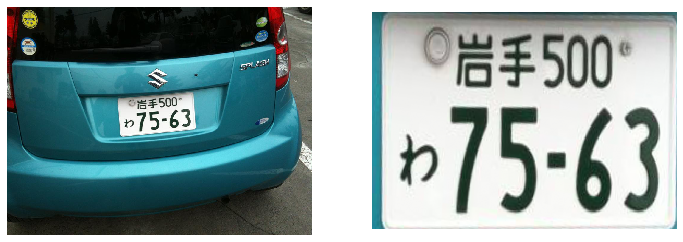

In [6]:
def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = image_paths[2]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])
plt.savefig("./tmp/stage1_result.png",dpi=300)

We have cropped the license plate into its own image, that could be processed further (more in stage 2).

Instead for now, we will take the cordinates that have been obtained and use them to draw a rectangle around the detected license plate area.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


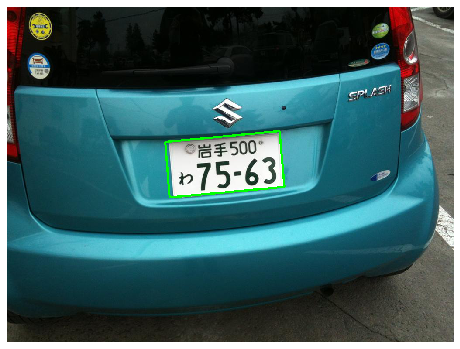

In [7]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

### Oh baby!

We have lit up the license plate area, exactly like we wanted. Now lets try something extra special.
YOLOAOTTAO (all of the things at once).

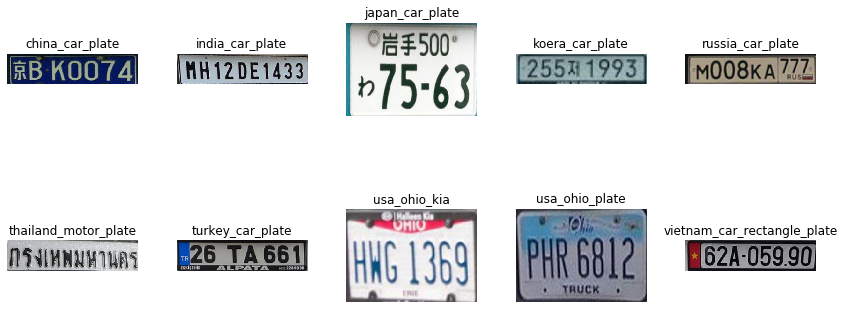

In [8]:
# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 2
fig_list = []

for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    LpImg,_ = get_plate(image_paths[i])
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()

### Multiple license plates.

This is totally gonna happen. We could have two or more cars in the frame at once and we would defintely want to capture all of them.

*I have not tested this model on 3 cars yet.*

Detect 2 plate(s) in mixed_plates_2


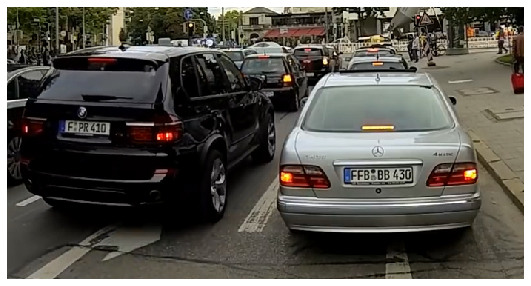

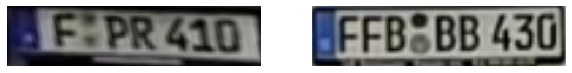

In [9]:
# Extract mutiple plate license in one image 

multiple_plates_image = "./input/mixed_plates_2.png"
LpImg,cor = get_plate(multiple_plates_image)

print("Detect %i plate(s) in"%len(LpImg),splitext(basename(multiple_plates_image))[0])

# Visualize the original image
plt.figure(figsize=(10,5))
plt.axis(False)
plt.imshow(preprocess_image(multiple_plates_image))

# Visualize the obtained plates
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(LpImg[1])
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

### On the Stage 2... Segmenting the detected license plates.